In [1]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.integration import lightgbm as lgb
import lightgbm as lgbm
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc, plot_pr2, plot_roc2
from doe_modules.ml.lightgbm_args import multiclass_args, regression_args

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    suffix: str = "_test4"

conf = Config(savefig=False)

In [3]:
data = pd.read_feather("/home/jovyan/out/esm_test4.feather")
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))
cloo_k, pb_k = data.cloo, data.pb

In [4]:
data

,cloo,pb,v,
0,0.000000,0.000000,0,neither
1,0.000000,0.000000,0,neither
2,0.000000,0.000000,0,neither
3,0.000000,0.000000,0,neither
4,0.000000,0.000000,0,neither
...,...,...,...,...
59044,0.750000,0.750000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both


In [5]:
def n_pathways(arr) -> int:
    return np.abs(arr)[:4].sum()

def n_edges(arr) -> int:
    return np.abs(arr)[4:].sum()

def pathway_coverage(arr) -> float:
    full = arr[:4].size
    return n_pathways(arr) / full

def pathway_positivity(arr):
    n_p = n_pathways(arr)
    return (arr[:4] == 1).sum() / n_p if n_p != 0 else 0

def pathway_negativity(arr):
    n_p = n_pathways(arr)
    return (arr[:4] == -1).sum() / n_p if n_p != 0 else 0

def positive_pathway_coverage(arr):
    return (arr[:4] == 1).sum() / arr[:4].size

def negative_pathway_coverage(arr):
    return (arr[:4] == -1).sum() / arr[:4].size

def sparse_pathway_coverage(arr):
    return (arr[:4] == 0).sum() / arr[:4].size

def edge_coverage(arr) -> float:
    full = arr[4:].size
    return n_edges(arr) / full

def n_pos(arr):
    return (arr[4:] == 1).sum()

def edge_positivity(arr):
    n_e = n_edges(arr)
    return n_pos(arr) / n_e if n_e != 0 else 0

def edge_negativity(arr):
    n_e = n_edges(arr)
    return (arr[4:] == -1).sum() / n_e if n_e != 0 else 0

def positive_edge_coverage(arr):
    return (arr[4:] == 1).sum() / arr[4:].size

def negative_edge_coverage(arr):
    return (arr[4:] == -1).sum() / arr[4:].size

def sparse_edge_coverage(arr):
    return (arr[4:] == 0).sum() / arr[4:].size

def n_eff(arr): 
    return np.array([
        (arr[4] != 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] != 0) & (arr[3] != 0),
        (arr[7] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] != 0) & (arr[3] != 0),
        (arr[9] != 0) & (arr[3] != 0),
    ]).sum()

def edge_effectivity(arr):
    n_e = n_edges(arr)
    return n_eff(arr) / n_e if n_e != 0 else 0

def n_effpos(arr):
    return np.array([
        (arr[4] > 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] > 0) & (arr[3] != 0),
        (arr[7] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] > 0) & (arr[3] != 0),
        (arr[9] > 0) & (arr[3] != 0),
    ]).sum()

def n_effneg(arr):
    return np.array([
        (arr[4] < 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] < 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] < 0) & (arr[3] != 0),
        (arr[7] < 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] < 0) & (arr[3] != 0),
        (arr[9] < 0) & (arr[3] != 0),
    ]).sum()


def effective_edge_positivity(arr):
    n_e = n_eff(arr)
    return n_effpos(arr) / n_e if n_e != 0 else 0


def effective_edge_negativity(arr):
    n_e = n_eff(arr)
    return n_effneg(arr) / n_e if n_e != 0 else 0

def edge_loading(arr):
    return np.abs(arr)[:4] * np.array([
        0,
        (arr[(4),] != 0).sum(),
        (arr[(5, 7),] != 0).sum() + (arr[(4, 7),] != 0).all(),
        (arr[(6, 8, 9),] != 0).sum() + (arr[(7, 9),] != 0).all() + (arr[(5, 9),] != 0).all() + ((arr[(4, 8),] != 0).all() or (arr[(4, 7, 9),] != 0).all()),
    ])

# def max_edge_loading(arr):
#     return  edge_loading(arr).max()

# def max_edge_density(arr):
#     return max_edge_loading(arr) / n_eff(arr) if n_eff(arr) != 0 else 0

# def mean_edge_density(arr):
#     return edge_loading(arr).mean() / n_eff(arr) if n_eff(arr) != 0 else 0

def max_edge_density(arr):
    return edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return edge_loading(arr).sum() / theoretical if theoretical != 0 else 0

def positive_edge_loading(arr):
    return (arr[:4] == 1) * np.array([
        0,
        (arr[(4),] == 1).sum(),
        (arr[(5, 7),] == 1).sum() + (arr[(4, 7),] == 1).all(),
        (arr[(6, 8, 9),] == 1).sum() + (arr[(7, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()),
    ])

def max_positive_edge_density(arr):
    return positive_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_positive_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return positive_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def synergetic_edge_loading(arr):
    return np.abs(arr)[:4] * np.array([
        0,
        (arr[(4),] == 1).sum(),
        (arr[(5, 7),] == 1).sum() + (arr[(4, 7),] == 1).all(),
        (arr[(6, 8, 9),] == 1).sum() + (arr[(7, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()),
    ])

def max_synergetic_edge_density(arr):
    return synergetic_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_synergetic_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return synergetic_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def factor_loading(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + (arr[(4),] != 0).sum(),
        1 + (arr[(7),] != 0).sum() + ((arr[(4, 7),] != 0).all() or (arr[(5),] != 0).all()),
        1 + (arr[(9),] != 0).sum() + ((arr[(7, 9),] != 0).all() or (arr[(8),] != 0).all()) + \
        ((arr[(4, 7, 9),] != 0).all() or (arr[(4, 8),] != 0).all() or (arr[(5, 9),] != 0).all() or (arr[(6),] != 0).all()),
    ])

def max_factor_density(arr):
    return factor_loading(arr).max() / len(arr[:4])

# def mean_factor_density(arr):
#     return factor_loading(arr).mean() / len(arr[:4])

def mean_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return factor_loading(arr).sum() / theoretical


def positive_factor_loading(arr):
    return (arr[:4] == 1) * np.array([
        1,
        1 + (arr[(4),] == 1).sum(),
        1 + (arr[(7),] == 1).sum() + ((arr[(4, 7),] == 1).all() or (arr[(5),] == 1).all()),
        1 + (arr[(9),] == 1).sum() + ((arr[(7, 9),] == 1).all() or (arr[(8),] == 1).all()) + \
        ((arr[(4, 7, 9),] == 1).all() or (arr[(4, 8),] == 1).all() or (arr[(5, 9),] == 1).all() or (arr[(6),] == 1).all()),
    ])

def max_positive_factor_density(arr):
    return positive_factor_loading(arr).max() / len(arr[:4])


def mean_positive_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return positive_factor_loading(arr).sum() / theoretical


def synergetic_factor_loading(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + (arr[(4),] == 1).sum(),
        1 + (arr[(7),] == 1).sum() + ((arr[(4, 7),] == 1).all() or (arr[(5),] == 1).all()),
        1 + (arr[(9),] == 1).sum() + ((arr[(7, 9),] == 1).all() or (arr[(8),] == 1).all()) + \
        ((arr[(4, 7, 9),] == 1).all() or (arr[(4, 8),] == 1).all() or (arr[(5, 9),] == 1).all() or (arr[(6),] == 1).all()),
    ])

def max_synergetic_factor_density(arr):
    return synergetic_factor_loading(arr).max() / len(arr[:4])


def mean_synergetic_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return synergetic_factor_loading(arr).sum() / theoretical


def cascade_length(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + np.max([0, (arr[(4),] != 0).sum()]),
        1 + np.max([
            0, (arr[(5),] != 0).sum(), (arr[(7),] != 0).sum(), 
            (arr[(4, 7),] != 0).sum() * (arr[(4, 7),] != 0).all()
        ]),
        1 + np.max([
            0, (arr[(6),] != 0).sum(), (arr[(8),] != 0).sum(), (arr[(9),] != 0).sum(), 
            (arr[(4, 8),] != 0).sum() * (arr[(4, 8),] != 0).all(), 
            (arr[(5, 9),] != 0).sum() * (arr[(5, 9),] != 0).all(), 
            (arr[(7, 9),] != 0).sum() * (arr[(7, 9),] != 0).all(),
            (arr[(4, 7, 9),] != 0).sum() * (arr[(4, 7, 9),] != 0).all()
        ]),
    ])

def max_cascade_length_ratio(arr):
    return cascade_length(arr).max() / arr[:4].size

def mean_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return cascade_length(arr).sum() / theoretical

def positive_cascade_length(arr):
    return (arr[:4] == 1) * np.array([
        1,
        1 + np.max([0, (arr[(4),] == 1).sum()]),
        1 + np.max([
            0, (arr[(5),] == 1).sum(), (arr[(7),] == 1).sum(), 
            (arr[(4, 7),] == 1).sum() * (arr[(4, 7),] == 1).all()
        ]),
        1 + np.max([
            0, (arr[(6),] == 1).sum(), (arr[(8),] == 1).sum(), (arr[(9),] == 1).sum(),
            (arr[(4, 8),] == 1).sum() * (arr[(4, 8),] == 1).all(), 
            (arr[(5, 9),] == 1).sum() * (arr[(5, 9),] == 1).all(), 
            (arr[(7, 9),] == 1).sum() * (arr[(7, 9),] == 1).all(),
            (arr[(4, 7, 9),] == 1).sum() * (arr[(4, 7, 9),] == 1).all()
        ]),
    ])

def max_positive_cascade_length_ratio(arr):
    return positive_cascade_length(arr).max() / arr[:4].size

def mean_positive_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return positive_cascade_length(arr).sum() / theoretical

def synergetic_cascade_length(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + np.max([0, (arr[(4),] == 1).sum()]),
        1 + np.max([
            0, (arr[(5),] == 1).sum(), (arr[(7),] == 1).sum(), 
            (arr[(4, 7),] == 1).sum() * (arr[(4, 7),] == 1).all()
        ]),
        1 + np.max([
            0, (arr[(6),] == 1).sum(), (arr[(8),] == 1).sum(), (arr[(9),] == 1).sum(),
            (arr[(4, 8),] == 1).sum() * (arr[(4, 8),] == 1).all(), 
            (arr[(5, 9),] == 1).sum() * (arr[(5, 9),] == 1).all(), 
            (arr[(7, 9),] == 1).sum() * (arr[(7, 9),] == 1).all(),
            (arr[(4, 7, 9),] == 1).sum() * (arr[(4, 7, 9),] == 1).all()
        ]),
    ])

def max_synergetic_cascade_length_ratio(arr):
    return synergetic_cascade_length(arr).max() / arr[:4].size

def mean_synergetic_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return synergetic_cascade_length(arr).sum() / theoretical

def cascade_coverage(arr):
    return np.sum([
        (arr[(0),] != 0).all(),
        (arr[(4, 1),] != 0).all(),
        (arr[(4, 7, 2),] != 0).all(),
        (arr[(4, 7, 9, 3),] != 0).all(),
        (arr[(4, 8, 3),] != 0).all(),
        (arr[(5, 2),] != 0).all(),
        (arr[(5, 9, 3),] != 0).all(),
        (arr[(6, 3),] != 0).all(),
        (arr[(1),] != 0).all(),
        (arr[(7, 2),] != 0).all(),
        (arr[(7, 9, 3),] != 0).all(),
        (arr[(8, 3),] != 0).all(),
        (arr[(2),] != 0).all(),
        (arr[(9, 3),] != 0).all(),
        (arr[(3),] != 0).all(),
    ]) / (2 ** arr[:4].size - 1)

def positive_cascade_coverage(arr):
    return np.sum([
        (arr[(0),] == 1).all(),
        (arr[(4, 1),] == 1).all(),
        (arr[(4, 7, 2),] == 1).all(),
        (arr[(4, 7, 9, 3),] == 1).all(),
        (arr[(4, 8, 3),] == 1).all(),
        (arr[(5, 2),] == 1).all(),
        (arr[(5, 9, 3),] == 1).all(),
        (arr[(6, 3),] == 1).all(),
        (arr[(1),] == 1).all(),
        (arr[(7, 2),] == 1).all(),
        (arr[(7, 9, 3),] == 1).all(),
        (arr[(8, 3),] == 1).all(),
        (arr[(2),] == 1).all(),
        (arr[(9, 3),] == 1).all(),
        (arr[(3),] == 1).all(),
    ]) / (2 ** arr[:4].size - 1)

def synergetic_cascade_coverage(arr):
    return np.sum([
        (arr[(0),] != 0).all(),
        (arr[(4),] == 1).all() & (arr[1] != 0),
        (arr[(4, 7),] == 1).all() & (arr[2] != 0),
        (arr[(4, 7, 9),] == 1).all() & (arr[3] != 0),
        (arr[(4, 8),] == 1).all() & (arr[3] != 0),
        (arr[(5),] == 1).all() & (arr[2] != 0),
        (arr[(5, 9),] == 1).all() & (arr[3] != 0),
        (arr[(6),] == 1).all() & (arr[3] != 0),
        (arr[(1),] != 0).all(),
        (arr[(7),] == 1).all() & (arr[2] != 0),
        (arr[(7, 9),] == 1).all() & (arr[3] != 0),
        (arr[(8),] == 1).all() & (arr[3] != 0),
        (arr[(2),] != 0).all(),
        (arr[(9),] == 1).all() & (arr[3] != 0),
        (arr[(3),] != 0).all(),
    ]) / (2 ** arr[:4].size - 1)

In [6]:
df = pd.DataFrame(dict(
    pathway_coverage=list(map(pathway_coverage, edges)),
    positive_pathway_coverage=list(map(positive_pathway_coverage, edges)),
    negative_pathway_coverage=list(map(negative_pathway_coverage, edges)),
    pathway_positivity=list(map(pathway_positivity, edges)),
    pathway_negativity=list(map(pathway_negativity, edges)),
    # sparse_pathway_coverage=list(map(sparse_pathway_coverage, edges)),
    edge_coverage=list(map(edge_coverage, edges)),
    positive_edge_coverage=list(map(positive_edge_coverage, edges)),
    negative_edge_coverage=list(map(negative_edge_coverage, edges)),
    edge_positivity=list(map(edge_positivity, edges)),
    edge_negativity=list(map(edge_negativity, edges)),
    # sparse_edge_coverage=list(map(sparse_edge_coverage, edges)),
    edge_effectivity=list(map(edge_effectivity, edges)),
    effective_edge_positivity=list(map(effective_edge_positivity, edges)),
    effective_edge_negativity=list(map(effective_edge_negativity, edges)),
    max_edge_density=list(map(max_edge_density, edges)),
    mean_edge_density=list(map(mean_edge_density, edges)),
    max_positive_edge_density=list(map(max_positive_edge_density, edges)),
    mean_positive_edge_density=list(map(mean_positive_edge_density, edges)),
    max_synergetic_edge_density=list(map(max_synergetic_edge_density, edges)),
    mean_synergetic_edge_density=list(map(mean_synergetic_edge_density, edges)),
    max_factor_density=list(map(max_factor_density, edges)),
    mean_factor_density=list(map(mean_factor_density, edges)),
    max_positive_factor_density=list(map(max_positive_factor_density, edges)),
    mean_positive_factor_density=list(map(mean_positive_factor_density, edges)),
    max_synergetic_factor_density=list(map(max_synergetic_factor_density, edges)),
    mean_synergetic_factor_density=list(map(mean_synergetic_factor_density, edges)),
    max_cascade_length_ratio=list(map(max_cascade_length_ratio, edges)),
    mean_cascade_length_ratio=list(map(mean_cascade_length_ratio, edges)),
    max_positive_cascade_length_ratio=list(map(max_positive_cascade_length_ratio, edges)),
    mean_positive_cascade_length_ratio=list(map(mean_positive_cascade_length_ratio, edges)),
    max_synergetic_cascade_length_ratio=list(map(max_synergetic_cascade_length_ratio, edges)),
    mean_synergetic_cascade_length_ratio=list(map(mean_synergetic_cascade_length_ratio, edges)),
    # cascade_coverage=list(map(cascade_coverage, edges)),
    # positive_cascade_coverage=list(map(positive_cascade_coverage, edges)),
    # synergetic_cascade_coverage=list(map(synergetic_cascade_coverage, edges)),
))

In [7]:
feat_names_exceptions = dict(
    sparse_pathway_coverage="pathway absence",
    sparse_edge_coverage="regulation absence",
    mean_edge_density="regulation weight coverage",
    mean_positive_edge_density="positive regulation weight coverage",
    mean_synergetic_edge_density="enhancing regulation weight coverage",
    mean_factor_density="factor weight coverage",
    mean_positive_factor_density="positive factor weight coverage",
    mean_synergetic_factor_density="enhancing factor weight coverage",
    mean_cascade_length_ratio="cascade length coverage",
    mean_positive_cascade_length_ratio="positive cascade length coverage",
    mean_synergetic_cascade_length_ratio="enhancing cascade length coverage",
)

feat_names_print = {
    v: feat_names_exceptions[v] if v in feat_names_exceptions else v.replace(
        "edge", "regulation").replace(
        "synergetic", "enhancing").replace(
        "max", "maximum").replace(
        "ratio", "scale"
    ).replace("_", " ") for v in df.columns
}

feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

feat_formula = dict(
    pathway_coverage=r"$\frac{|P|}{n}$",
    pathway_positivity=r"$\frac{|P_+|}{|P|}$",
    pathway_negativity=r"\frac{|P_-|}{|P|}",
    positive_pathway_coverage=r"$\frac{|P_+|}{n}$",
    negative_pathway_coverage=r"$\frac{|P_-|}{n}$",
    sparse_pathway_coverage=r"$\frac{n-|P|}{n}$",
    edge_coverage=r"$\frac{|R|}{{}_n \mathrm{C}_2}$",
    edge_positivity=r"$\frac{|R_+|}{|R|}$",
    edge_negativity=r"$\frac{|R_-|}{|R|}$",
    positive_edge_coverage=r"$\frac{|R_+|}{{}_n \mathrm{C}_2}$",
    negative_edge_coverage=r"$\frac{|R_-|}{{}_n \mathrm{C}_2}$",
    sparse_edge_coverage=r"$\frac{{}_n \mathrm{C}_2-|R|}{{}_n \mathrm{C}_2}$",
    edge_effectivity=r"$\frac{|R^*|}{|R|}$",
    effective_edge_positivity=r"$\frac{|R^*_+|}{|R^*|}$",
    effective_edge_negativity=r"$\frac{|R^*_-|}{|R^*|}$",
    max_edge_density=r"$\frac{\max RW}{|R^*|}$",
    mean_edge_density=r"$\frac{\sum RW}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_positive_edge_density=r"$\frac{\max RW_+}{|R^*|}$",
    mean_positive_edge_density=r"$\frac{\sum RW_+}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_synergetic_edge_density=r"$\frac{\max RW_&}{|R^*|}$",
    mean_synergetic_edge_density=r"$\frac{\sum RW_&}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_factor_density=r"$\frac{\max RFW}{n}$",
    mean_factor_density=r"$\frac{\sum RFW}{\sum^n_{p=1}p}$",
    max_positive_factor_density=r"$\frac{\max RFW_+}{n}$",
    mean_positive_factor_density=r"$\frac{\sum RFW_+}{\sum^n_{p=1}p}$",
    max_synergetic_factor_density=r"$\frac{\max RFW_&}{n}$",
    mean_synergetic_factor_density=r"$\frac{\sum RFW_&}{\sum^n_{p=1}p}$",
    max_cascade_length_ratio=r"$\frac{\max CL}{n}$",
    mean_cascade_length_ratio=r"$\frac{\sum CL}{\sum^n_{p=1}p}$",
    max_positive_cascade_length_ratio=r"$\frac{\max CL_+}{n}$",
    mean_positive_cascade_length_ratio=r"$\frac{\sum CL_+}{\sum^n_{p=1}p}$",
    max_synergetic_cascade_length_ratio=r"$\frac{\max CL_&}{n}$",
    mean_synergetic_cascade_length_ratio=r"$\frac{\sum CL_&}{\sum^n_{p=1}p}$",
    # cascade_coverage=r"$\frac{|C|}{2^n-1}$",
    # positive_cascade_coverage=r"$\frac{|C_+|}{2^n-1}$",
    # synergetic_cascade_coverage=r"$\frac{|C_&|}{2^n-1}$",
)

df.max(axis=0)

fig, ax = plt.subplots(figsize=(10, 11))

sns.heatmap(
    df.corr(method="spearman"), vmin=-1, vmax=1, square=True,
    cmap="coolwarm", cbar_kws={"label": "Spearman Correlation Coefficient", "shrink": .7}
)

ax.set_xticklabels([f"{feat_names_print[name]} ({feat_names_short[name]})" for name in df.columns])
ax.set_yticklabels([f"{feat_names_short[name]}" for name in df.columns]);

if conf.savefig:
    fig.savefig(f"{conf.out}/feat_corr{conf.suffix}", **kwarg_savefig)

fig, ax = plt.subplots(6, 6, figsize=(20, 20))
plt.subplots_adjust(wspace=.3, hspace=.3)

sorted_idx = data.sort_values("v").index

ax_locations = {
    v: i for i, v in enumerate(
        [ii for ii in range(5)] +  [6 + ii for ii in range(8)] + [18 + ii for ii in range(18)]
    )
}

for i, a in enumerate(ax.ravel()):
    if i in ax_locations:
        sns.violinplot(
            data=df.loc[sorted_idx, :], 
            x=data.loc[sorted_idx, ""], y=df.columns[ax_locations[i]], 
            ax=a,
            cut=0, palette=[".7", "C0", "C1", "C4"],
            inner="quart", 
            fill=False
        )
        a.set(ylabel="", title=feat_names_short[df.columns[ax_locations[i]]])
    else:
        a.axis("off")

if conf.savefig:
    fig.savefig(f"{conf.out}/feat_violin{conf.suffix}", **kwarg_savefig)

In [18]:
x_tr, x_te, y_tr, y_te = train_test_split(
    df, 
    # data.loc[:, "v"],
    data.pb - data.cloo,
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)


# params = multiclass_args(
#     num_class=data.v.unique().size
# )
params = regression_args()

In [14]:
ds_idx = np.vectorize(
    lambda idx: (np.arange(3) * np.array([idx in y_tr, idx in y_v, idx in y_te])).sum()
)(data.index)
ds_name = np.vectorize(
    lambda dsidx: ["Training", "Validation", "Test"][dsidx]
)(ds_idx)

ds_tally = data.assign(
        dataset=pd.Series(ds_name, index=data.index)
    ).assign(dsidx=pd.Series(ds_idx, index=data.index)).loc[:, ["dsidx", "dataset", "v", ""]].value_counts().sort_index()

ds_tally_rate = (ds_tally / np.array([y_tr.size, y_v.size, y_te.size] * 4).reshape(4, 3).T.ravel())

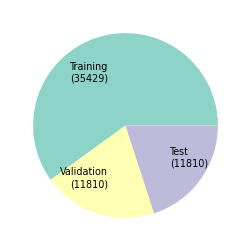

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.pie(
    [y_tr.size, y_v.size, y_te.size], 
    labels=[f"{kind}\n({num})" for kind, num in zip(["Training", "Validation", "Test"],  [y_tr.size, y_v.size, y_te.size])], 
    labeldistance=.6, textprops={'size': 'x-small'},
    colors=[plt.cm.Set3(i) for i in range(3)]
)

if conf.savefig:
    fig.savefig(f"{conf.out}/holdout{conf.suffix}", **kwarg_savefig)

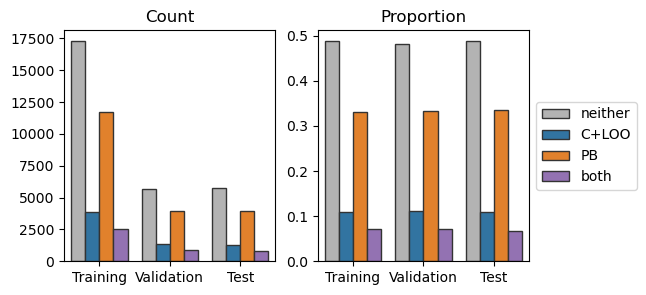

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

for i, (ds, a) in enumerate(zip([ds_tally, ds_tally_rate], ax.ravel())):
    sns.barplot(
        data=ds.reset_index(),
        x="dataset", y=0, hue="", ax=a, 
        palette=[".7", "C0", "C1", "C4"],
        edgecolor=".2"
    )
    a.set(xlabel="", ylabel="", title=["Count", "Proportion"][i])

ax[0].get_legend().remove()
ax[1].legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{conf.out}/holdout_classbalance{conf.suffix}", **kwarg_savefig)

In [19]:
logger = {}

model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    # verbosity=-1,
    callbacks=[
        lgbm.early_stopping(100), 
        lgbm.log_evaluation(10000), 
        lgbm.record_evaluation(logger)
    ]
)

[I 2025-10-28 08:03:43,243] A new study created in memory with name: no-name-f9996eeb-19bc-4339-88dc-3818b7ad45fa


In [20]:
%%capture
model.run()

[I 2025-10-28 08:03:45,592] Trial 0 finished with value: 0.10212876066075754 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10212876066075754.
[I 2025-10-28 08:03:45,861] Trial 1 finished with value: 0.10245904909785693 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.10212876066075754.
[I 2025-10-28 08:03:46,081] Trial 2 finished with value: 0.1025776562243225 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.10212876066075754.
[I 2025-10-28 08:03:46,318] Trial 3 finished with value: 0.10232956538921943 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.10212876066075754.
[I 2025-10-28 08:03:46,549] Trial 4 finished with value: 0.10308513368163309 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10212876066075754.
[I 2025-10-28 08:03:46,821] Trial 5 finished with value: 0.10212537243887808 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with 

In [21]:
tuned = model.get_best_booster()

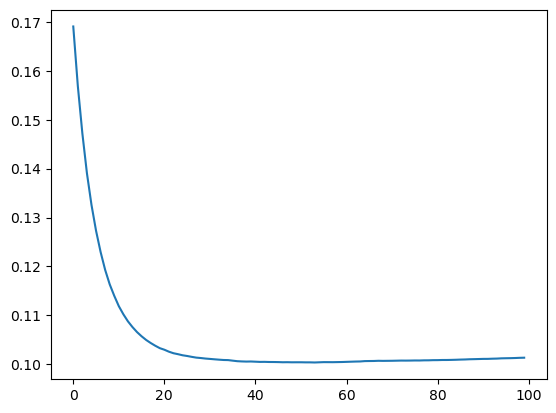

In [26]:
plt.plot(
    # logger["valid_0"]["multi_logloss"]\
    logger["valid_0"]["l2"]
)

In [30]:
from sklearn.metrics import r2_score

In [31]:
r2_score(y_te, tuned.predict(x_te))

0.45623552808113044

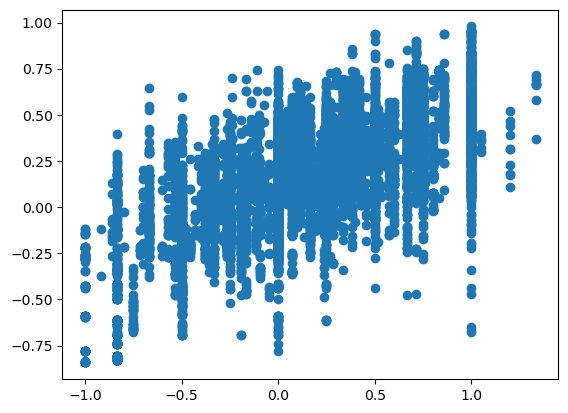

In [29]:
plt.scatter(
    y_te, tuned.predict(x_te)
)

In [19]:
from sklearn.preprocessing import label_binarize

In [20]:
testx = x_te.loc[y_te.sort_values().index, :]
testy = y_te.sort_values()

In [21]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_roc(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

if conf.savefig:
    fig.savefig(f"{conf.out}/auc{conf.suffix}", **kwarg_savefig)

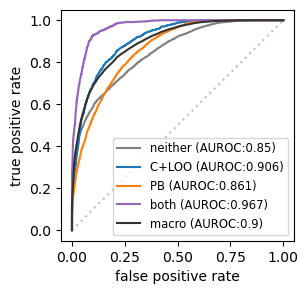

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_roc2(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])},
    minimalist=True
)

ax.legend(fontsize="small")
ax.set_title(None)

if conf.savefig:
    fig.savefig(f"{conf.out}/auc{conf.suffix}", **kwarg_savefig)

fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_pr(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pr{conf.suffix}", **kwarg_savefig)

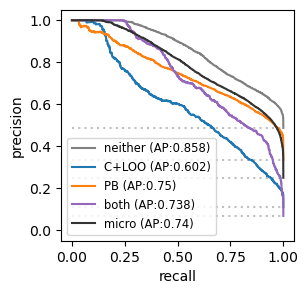

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_pr2(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])},
    minimalist=True
)

ax.set_ylim(ax.get_xlim())

ax.legend(fontsize="small")
ax.set_title(None)

if conf.savefig:
    fig.savefig(f"{conf.out}/pr{conf.suffix}", **kwarg_savefig)

In [24]:
from sklearn.metrics import confusion_matrix

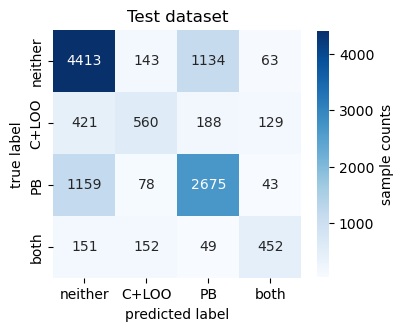

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(testy, tuned.predict(testx).argmax(axis=1)), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts", "shrink": .8}
)

ax.set_xticklabels(["neither", "C+LOO", "PB", "both"])
ax.set_yticklabels(["neither", "C+LOO", "PB", "both"])
ax.set(xlabel="predicted label", ylabel="true label", title="Test dataset");

if conf.savefig:
    fig.savefig(f"{conf.out}/confusion_matrix{conf.suffix}", **kwarg_savefig)

In [26]:
shap.initjs()

In [27]:
testx.columns = [feat_names_short[name] for name in df.columns]

In [28]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

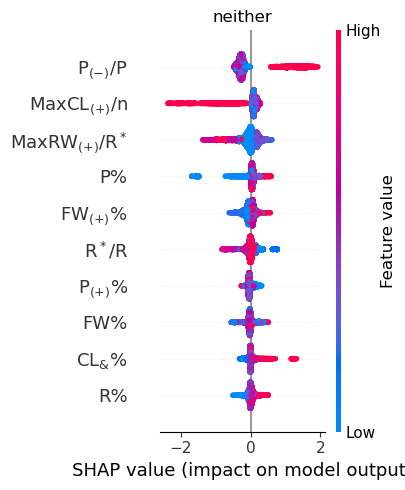

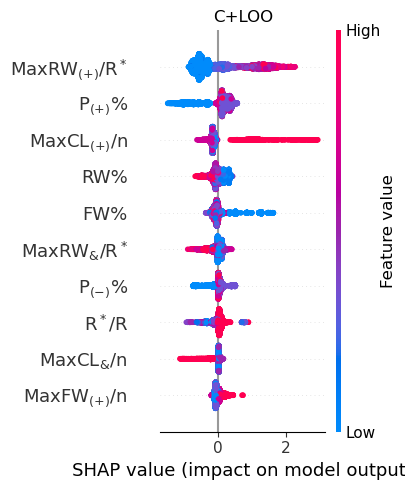

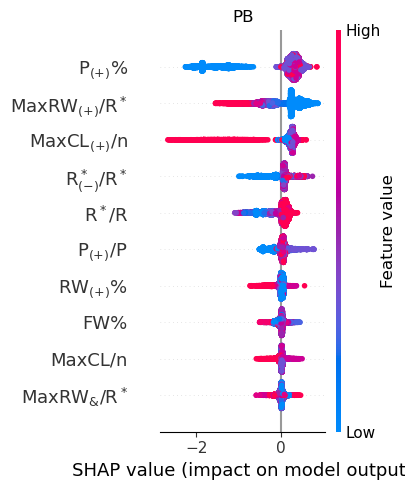

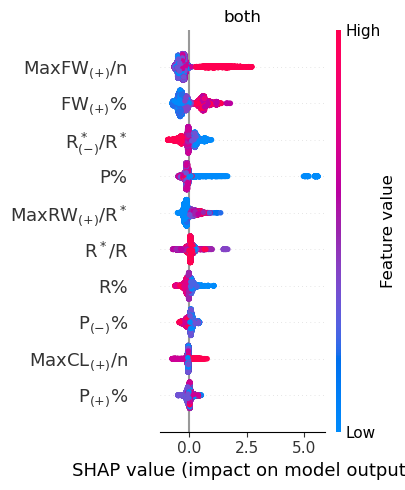

In [29]:
for i in testy.unique():
    title = {i: k for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}[i]
    plt.axes(title=title)
    shap.summary_plot(
        shap_values[:, :, i], testx, 
        # max_display=df.shape[1], 
        max_display=10,
        show=False,
        plot_size=(4, 5)
    )
    plt.savefig(f"{conf.out}/shap_{title}.png", **kwarg_savefig)
    plt.close()
    
for i in testy.unique():
    title = {i: k for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}[i]
    plt.axes(title=title)
    shap.summary_plot(
        shap_values[:, :, i], testx, 
        # max_display=df.shape[1], 
        max_display=10,
        show=True,
        plot_size=(4, 5)
    )

In [297]:
arr2idx = lambda arr: sum([[1, 2, 0][val] * (3 ** loc) for loc, val in enumerate(arr[::-1])])

In [300]:
arr2idx(edges[54321].tolist())

54321

In [301]:
arr2idx([0, 0, 0, 0, -1, -1, -1, -1, -1, -1])

29160

In [302]:
arr2idx([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

29888

In [295]:
edges[0]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [291]:
edges

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  0],
       [-1, -1, -1, ..., -1, -1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ...,  1,  1,  0],
       [ 1,  1,  1, ...,  1,  1,  1]])

In [307]:
hoge.iloc[[i for i in range(len(edges)) if not 29160 <= i <= 29888], :].drop(["pb", "v", ""], axis=1).corr(method="spearman").loc[:, "cloo"]

cloo                                    1.000000
pathway_coverage                       -0.040303
positive_pathway_coverage              -0.073703
negative_pathway_coverage              -0.016858
pathway_positivity                      0.008675
pathway_negativity                     -0.008675
edge_coverage                           0.001395
positive_edge_coverage                  0.069401
negative_edge_coverage                 -0.066910
edge_positivity                         0.076514
edge_negativity                        -0.076852
edge_effectivity                       -0.074758
effective_edge_positivity               0.108751
effective_edge_negativity              -0.109034
max_edge_density                        0.000873
mean_edge_density                      -0.043787
max_positive_edge_density               0.101186
mean_positive_edge_density              0.056035
max_synergetic_edge_density             0.120292
mean_synergetic_edge_density            0.050684
max_factor_density  

In [306]:
hoge = dat.copy()
hoge.drop(["pb", "v", ""], axis=1).corr(method="spearman").loc[:, "cloo"]

cloo                                    1.000000
pathway_coverage                       -0.068342
positive_pathway_coverage              -0.097093
negative_pathway_coverage              -0.039581
pathway_positivity                     -0.016215
pathway_negativity                     -0.030311
edge_coverage                           0.001739
positive_edge_coverage                  0.068849
negative_edge_coverage                 -0.066047
edge_positivity                         0.075744
edge_negativity                        -0.076073
edge_effectivity                       -0.101079
effective_edge_positivity               0.085204
effective_edge_negativity              -0.129239
max_edge_density                       -0.032782
mean_edge_density                      -0.068189
max_positive_edge_density               0.085843
mean_positive_edge_density              0.041641
max_synergetic_edge_density             0.097285
mean_synergetic_edge_density            0.029211
max_factor_density  

In [103]:
dat = pd.concat([data, df], axis=1).assign(
    pathway_sparsity=1 - df.loc[:, "pathway_coverage"]
)

dat = dat.assign(
    cai=[
        harmonic_mean(x, y, z) for x, y, z in zip(
            df.loc[:, "max_positive_edge_density"], 
            df.loc[:, "edge_coverage"], 
            dat.loc[:, "pathway_sparsity"]
        )
    ]
)
# .assign(
#     max_synergetic_edge_loading=list(map(lambda arr: synergetic_edge_loading(arr).max(), edges))
# ).assign(
#     max_cascade_length=list(map(lambda arr: cascade_length(arr).max(), edges))
# ).assign(
#     n_effpos=list(map(n_effpos, edges)),
# ).assign(
#     cai=(df.loc[:, "edge_coverage"] + df.loc[:, "effective_edge_positivity"]) / 2
# ).assign(
#     cai2=(df.loc[:, "edge_coverage"] + df.loc[:, "edge_positivity"]) / 2
# ).assign(
#     cai3=[harmony(x, y, z) for x, y, z in zip(df.loc[:, "max_synergetic_edge_density"], df.loc[:, "edge_coverage"], df.loc[:, "effective_edge_positivity"])]
# ).assign(
#     cai4=[harmony(ec, eep) for ec, eep in zip(df.loc[:, "edge_coverage"], df.loc[:, "effective_edge_positivity"])]
# ).assign(
#     cai5=[harmony(sed, clr) for sed, clr in zip(df.loc[:, "max_synergetic_edge_density"], df.loc[:, "max_cascade_length_ratio"])]
# ).assign(
#     cai6=(df.loc[:, "max_cascade_length_ratio"] + df.loc[:, "max_synergetic_cascade_length_ratio"]) / 2
# )

fig, ax = plt.subplots(2, df.columns.size, figsize=(4 * df.columns.size, 6), sharey=True)

for i, k in enumerate(df.columns):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [104]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

key_r, key_c = "max_synergetic_edge_loading", "max_cascade_length"
label_r, label_c = "MaxSEL", "MaxCL"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

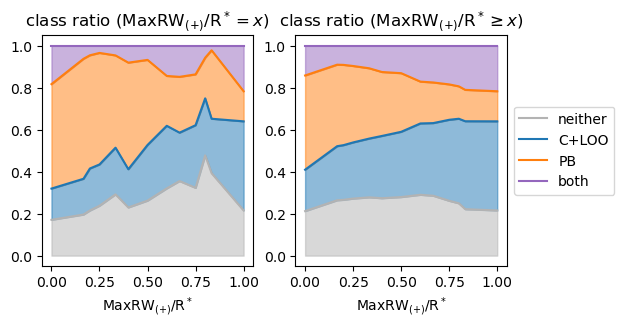

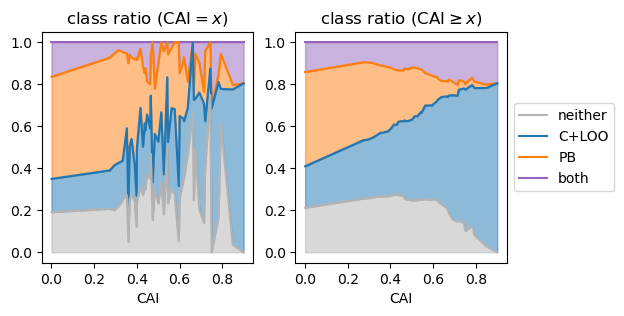

In [309]:
for key in [
    # *df.columns,
    # "max_factor_density",
    # "max_synergetic_edge_density", 
    "max_positive_edge_density",
    # "max_cascade_length_ratio", 
    "cai", 
    # "cai4", "cai6"
]:
    label=feat_names_short[key] if key in feat_names_short else key.upper()
    
    stdf2 = stacked_tally(dat, key, "", stack_key="v", ratio=True)
    stdf3 = stacked_tally(dat, key, "", stack_key="v", ratio=True, geq=True)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    for i, k in enumerate(stdf2.loc[:, "index"].unique()):
        sns.lineplot(
            data=stdf2[stdf2.loc[:, "index"] == k],
            x="key", y="",
            color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
            zorder=-i, label=k
        )
        sns.lineplot(
            data=stdf3[stdf3.loc[:, "index"] == k],
            x="key", y="",
            color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
            zorder=-i, label=k
        )

    for line_idx, line in enumerate(ax[0].lines):
        x0, y0 = line.get_xydata().T
        ax[0].fill_between(x0, 0 if line_idx == 0 else bottom, y0, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
        bottom = y0

    for line_idx, line in enumerate(ax[1].lines):
        x1, y1 = line.get_xydata().T
        ax[1].fill_between(x1, 0 if line_idx == 0 else bottom, y1, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
        bottom = y1

    # ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
    # ax.xaxis.set_tick_params(rotation=90)

    ax[0].get_legend().remove()
    ax[1].legend(loc="center left", bbox_to_anchor=(1, .5))
    ax[0].set(xlabel=label, title=f"class ratio ({label}$=x$)")
    ax[1].set(xlabel=label, title=f"class ratio ({label}$\geq x$)")

    if conf.savefig:
        fig.savefig(f"{conf.out}/bar_{key}{conf.suffix}", **kwarg_savefig)

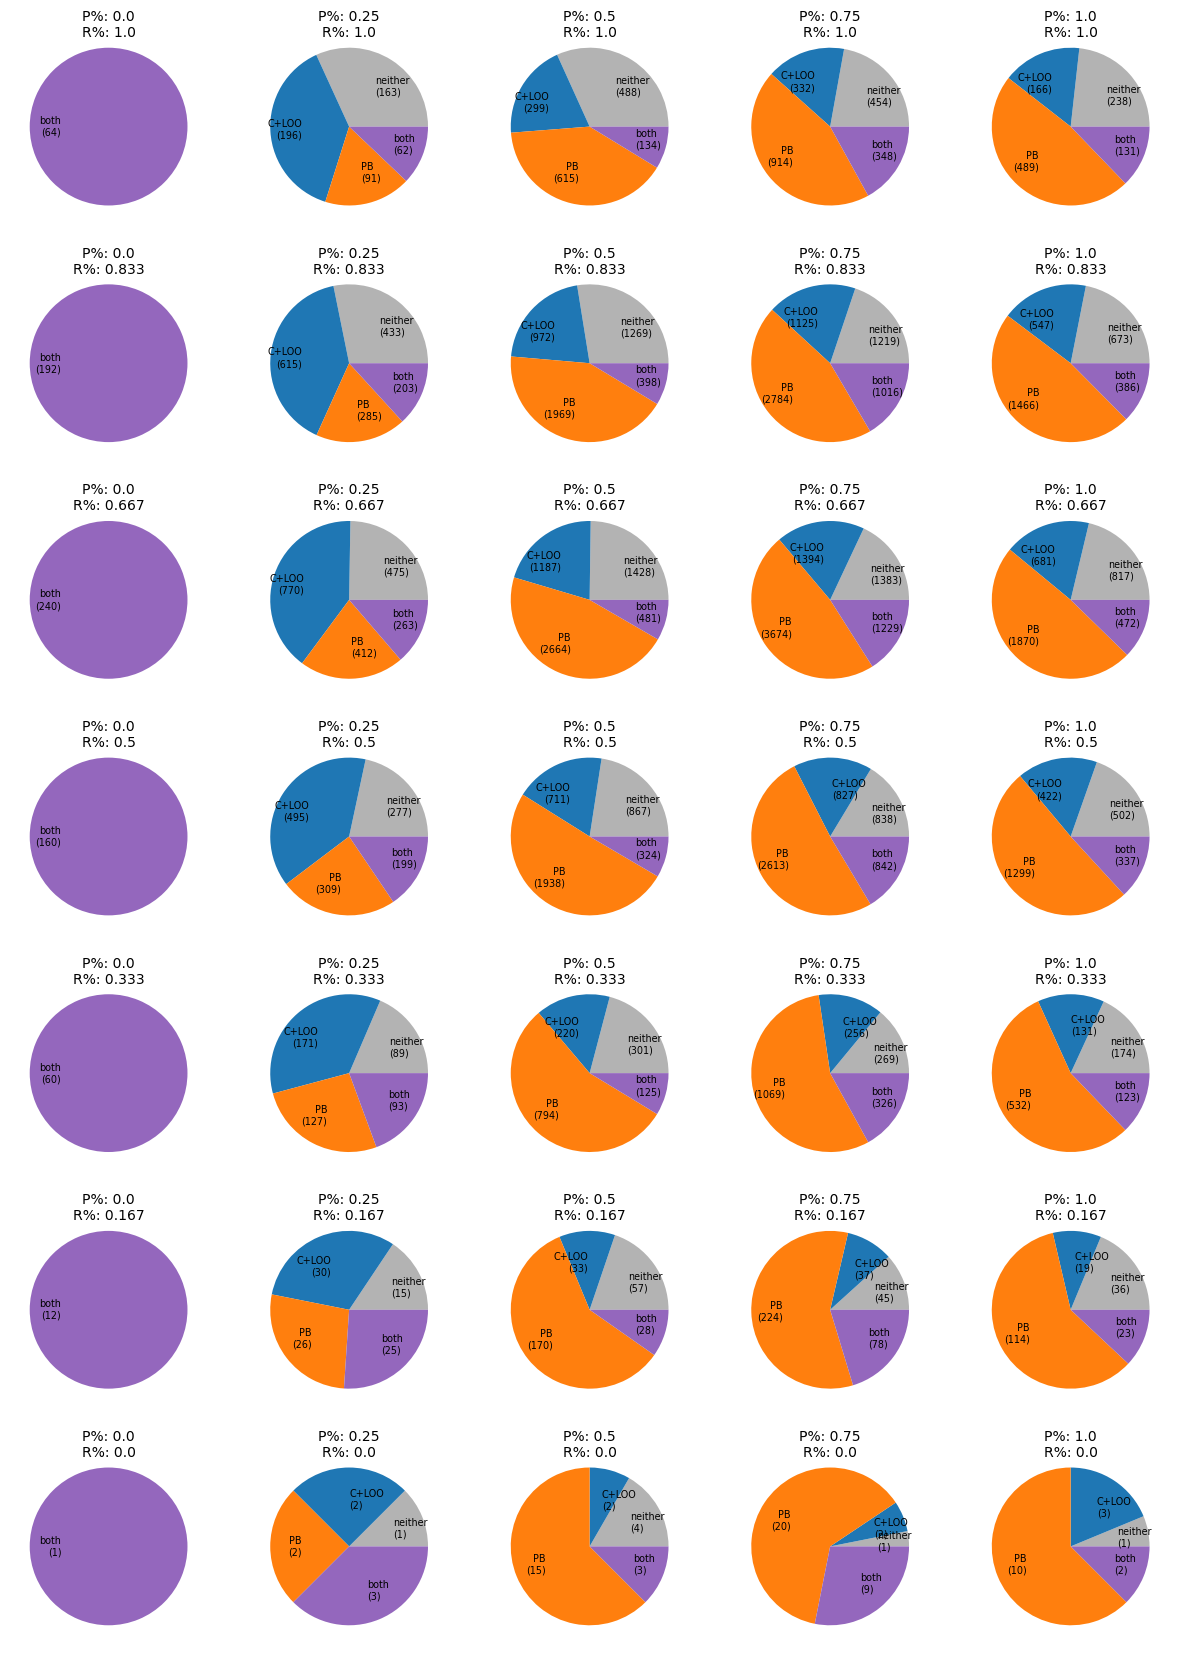

In [107]:
key_r, key_c = "edge_coverage", "pathway_coverage"
label_r, label_c = feat_names_short[key_r], feat_names_short[key_c]
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
val_r, val_c = np.sort(row.unique())[::-1], np.sort(col.unique())
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = [
        np.where(
            (dat.loc[:, key_r] == val_r[i // ncol]) & (dat.loc[:, key_c] == val_c[i % ncol]) & (dat.loc[:, "v"] == idx)
        )[0].size for idx in range(4)
    ]
    if np.sum(_d) == 0:
        a.text(0.5, 0.5, "N/A", ha="center", va="center")
        a.text(
            0.5, .95, 
            f"{label_r}: {(val_r[i // ncol]).round(3)}\n{label_c}: {(val_c[i % ncol]).round(3)}", 
            ha="center", va="bottom"
        )
        a.axis("off")
    else:
        a.pie(
            _d, labels=[f"{k}\n({_d[idx]})" if _d[idx]!=0 else "" for idx, k in d_label.items()], 
            labeldistance=.6, textprops={'size': 'x-small'},
            colors=[d_color[k] for k in d_label]
        )
        latexify = lambda name: "_{".join(name.split("_")) + "}"
        a.text(
            0, 1.1, 
            f"{label_c}: {(val_c[i % ncol]).round(3)}\n{label_r}: {(val_r[i // ncol]).round(3)}", 
            ha="center", va="bottom"
        )

if conf.savefig:
    fig.savefig(f"{conf.out}/venn_{key_c}_vs_{key_r}{conf.suffix}", **kwarg_savefig)

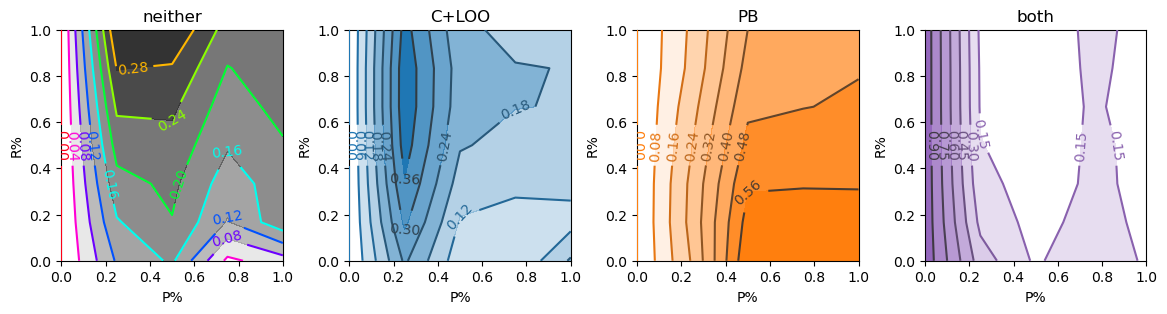

In [308]:
import matplotlib.colors as mcolors

keyx = "pathway_coverage"
keyy = "edge_coverage"

x1d = np.sort(dat.loc[:, keyx].unique())
y1d = np.sort(dat.loc[:, keyy].unique())
x2d, y2d = np.meshgrid(x1d, y1d)


def query_ratio(sorted_df, key):
    df_vals = sorted_df.value_counts() / sorted_df.size
    return df_vals[key] if key in df_vals.index else 0

df_ratios = pd.DataFrame({
    keyx: x2d.ravel(),
    keyy: y2d.ravel(),
    **{
        k: np.array([
            query_ratio(
                dat[(dat.loc[:, keyx] == x) & (dat.loc[:, keyy] == y)].v,
                k
            ) for x, y in zip(x2d.ravel(), y2d.ravel())
        ]) for k in np.sort(dat.v.unique())
    }
    
})

fig, ax = plt.subplots(
    1, 4, figsize=(14, 3), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, a in enumerate(ax.ravel()):
    
    rgb = mcolors.to_rgb({0: ".2", 1: "C0", 2: "C1", 3: "C4"}[i])
    cmap_contour = mcolors.ListedColormap(
        [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
    )
    
    a.contourf(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]])
    )
    contour = a.contour(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap="hsv_r" if i == 0 else cmap_contour, 
        zorder=100
    )
    contour.clabel(fmt=f'%.{2}f')
    a.set(
        title={i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}[i],
        xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
    )

if conf.savefig:
    fig.savefig(f"{conf.out}/contour_{key_c}_vs_{key_r}{conf.suffix}", **kwarg_savefig)

Text(0.5, 0.98, 'Simulators randomly generated with ESM9')

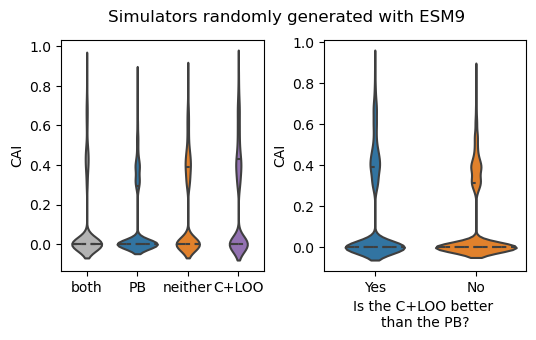

In [311]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
plt.subplots_adjust(wspace=.3)
sns.violinplot(data=dat, x="", y="cai", ax=ax[0], palette=[".7", "C0", "C1", "C4"], inner="quart")

sns.violinplot(
    data=dat.assign(
        better_with_cloo=list(map(lambda boolean: ["No", "Yes"][boolean], dat.cloo >= dat.pb))
    ).sort_values("better_with_cloo", ascending=False), 
    x="better_with_cloo", y="cai",
    inner="quart"
)

ax[1].set_xlabel("Is the C+LOO better \nthan the PB?")

[a.set(ylabel="CAI") for a in ax.ravel()]

plt.suptitle("Simulators randomly generated with ESM9")

# if conf.savefig:
#     fig.savefig(f"{outputdir}/cai_{conf.suffix}", **kwarg_savefig)

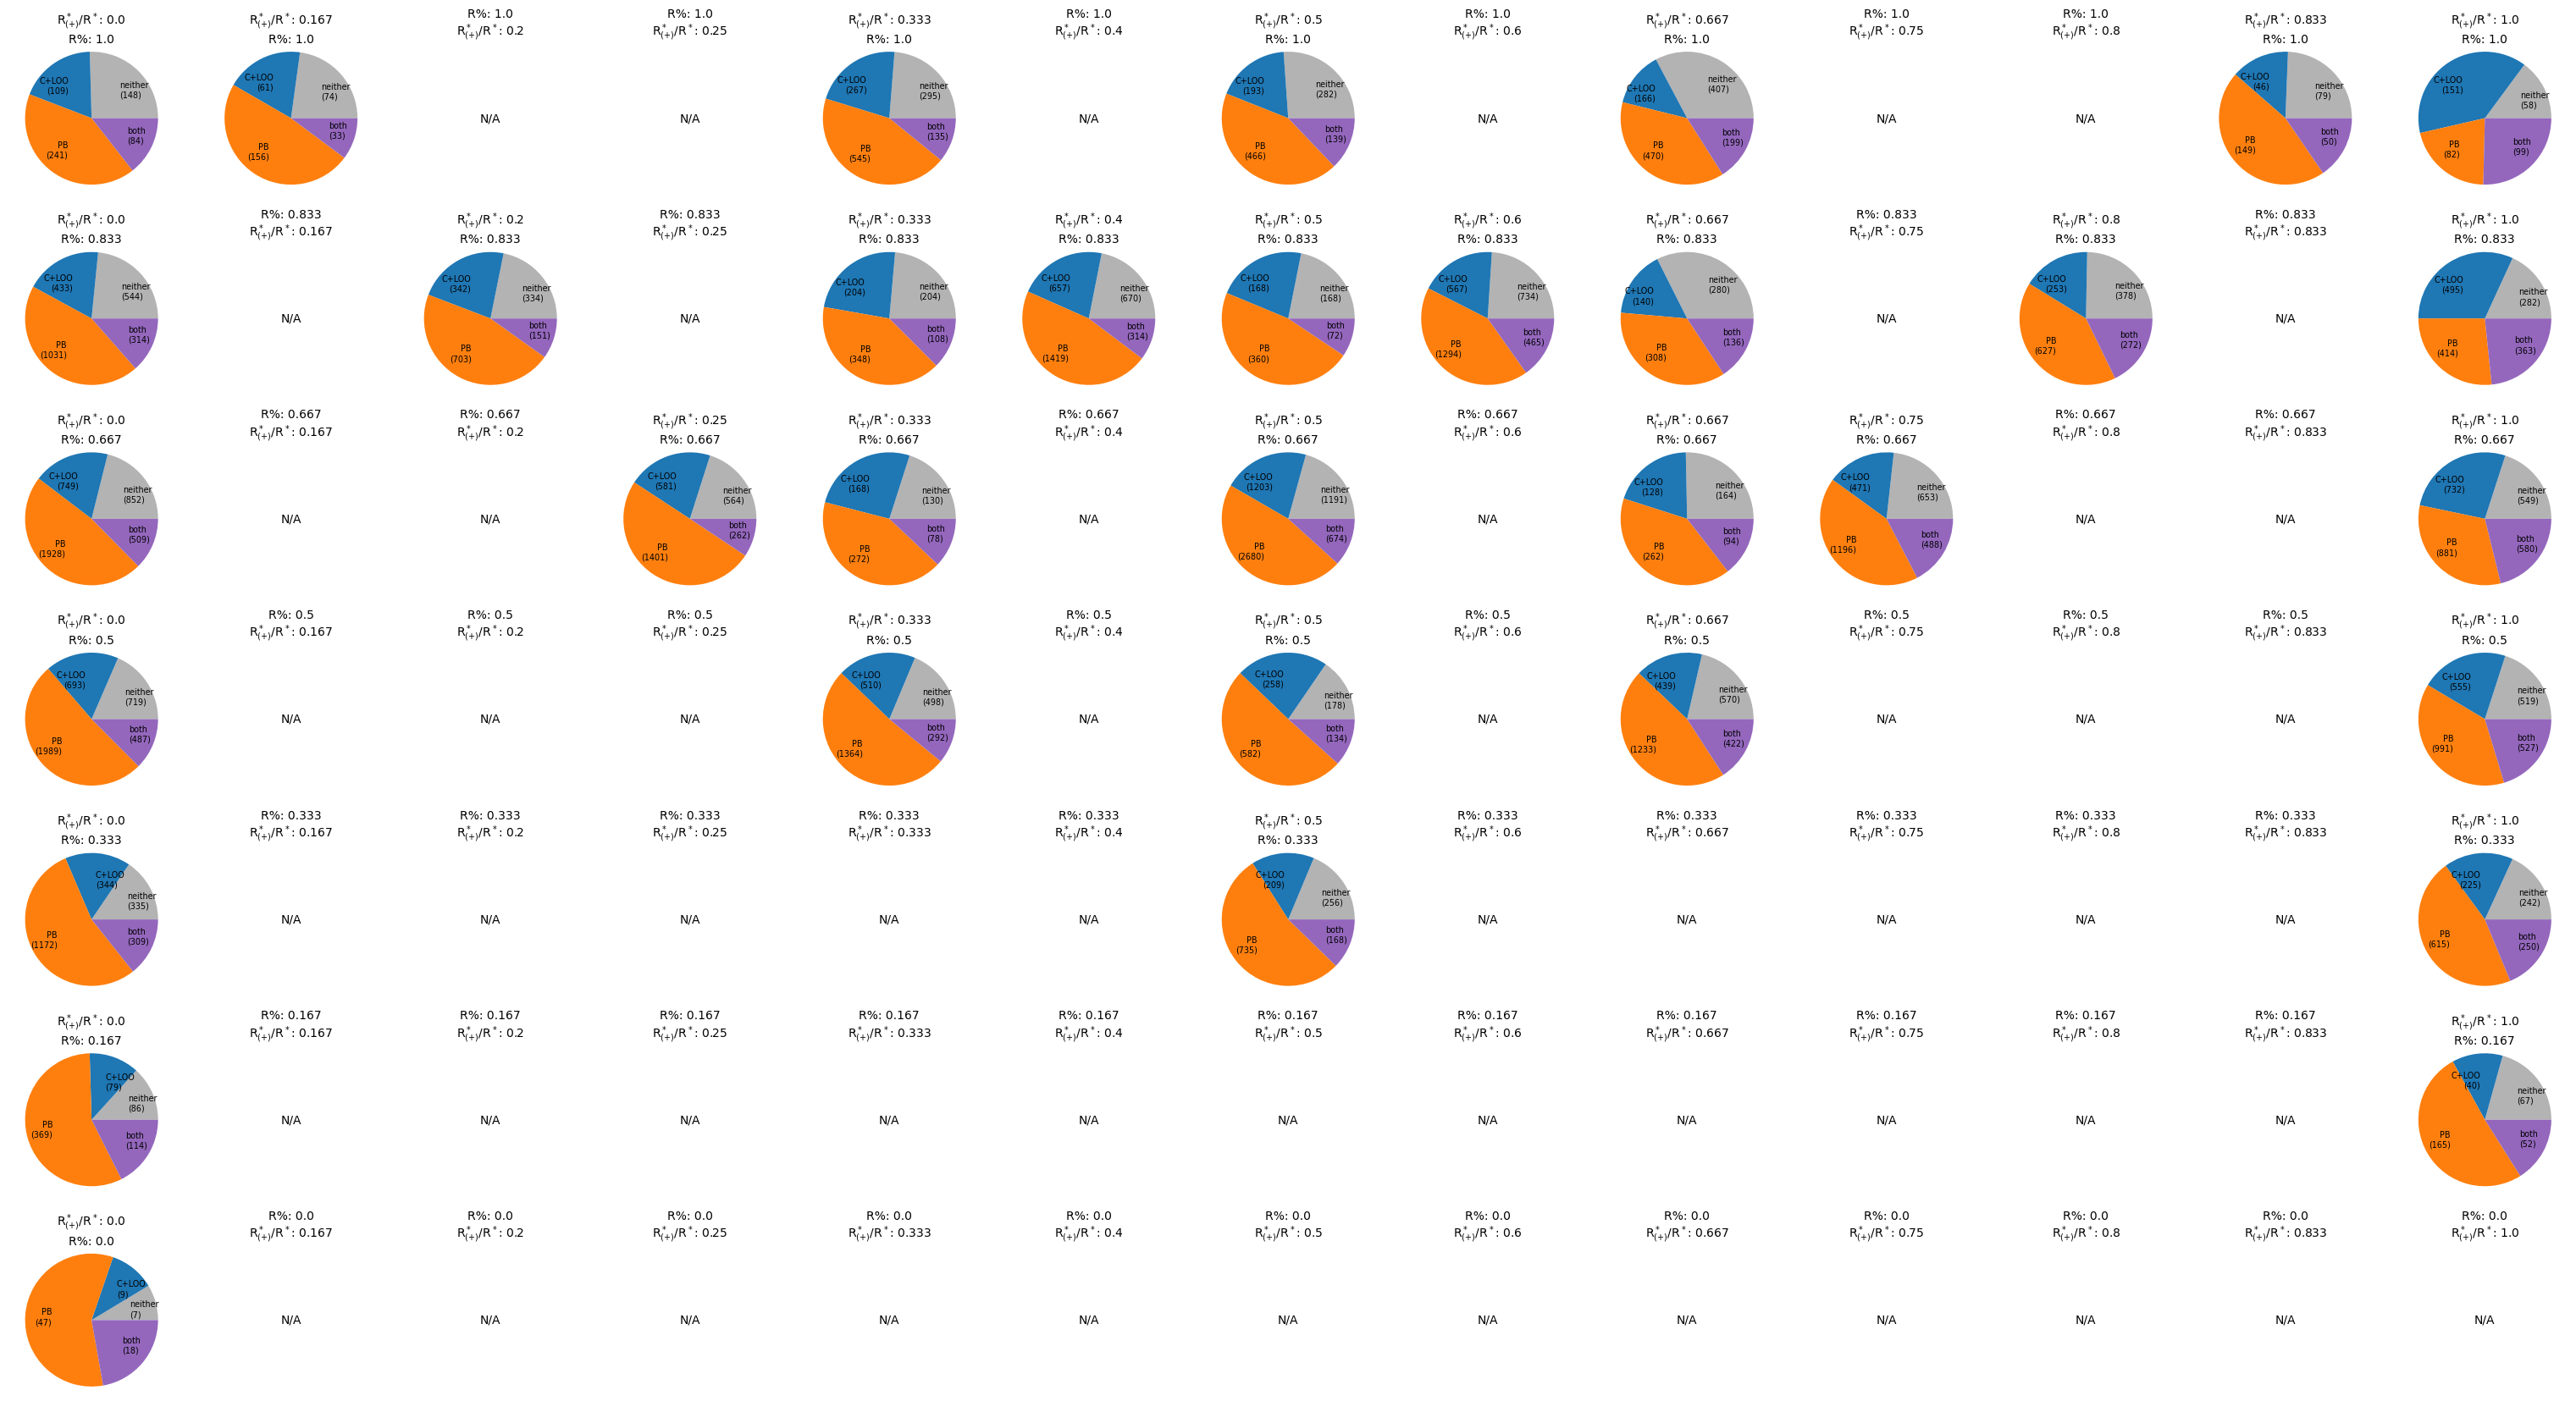

In [92]:
key_r, key_c = "edge_coverage", "effective_edge_positivity"
label_r, label_c = feat_names_short[key_r], feat_names_short[key_c]
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
val_r, val_c = np.sort(row.unique())[::-1], np.sort(col.unique())
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = [
        np.where(
            (dat.loc[:, key_r] == val_r[i // ncol]) & (dat.loc[:, key_c] == val_c[i % ncol]) & (dat.loc[:, "v"] == idx)
        )[0].size for idx in range(4)
    ]
    if np.sum(_d) == 0:
        a.text(0.5, 0.5, "N/A", ha="center", va="center")
        a.text(
            0.5, .95, 
            f"{label_r}: {(val_r[i // ncol]).round(3)}\n{label_c}: {(val_c[i % ncol]).round(3)}", 
            ha="center", va="bottom"
        )
        a.axis("off")
    else:
        a.pie(
            _d, labels=[f"{k}\n({_d[idx]})" if _d[idx]!=0 else "" for idx, k in d_label.items()], 
            labeldistance=.6, textprops={'size': 'x-small'},
            colors=[d_color[k] for k in d_label]
        )
        latexify = lambda name: "_{".join(name.split("_")) + "}"
        a.text(
            0, 1.1, 
            f"{label_c}: {(val_c[i % ncol]).round(3)}\n{label_r}: {(val_r[i // ncol]).round(3)}", 
            ha="center", va="bottom"
        )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/venn_{key_c}_vs_{key_r}{conf.suffix}", **kwarg_savefig)

In [47]:
from itertools import product
from doe_modules.simulation import Test4

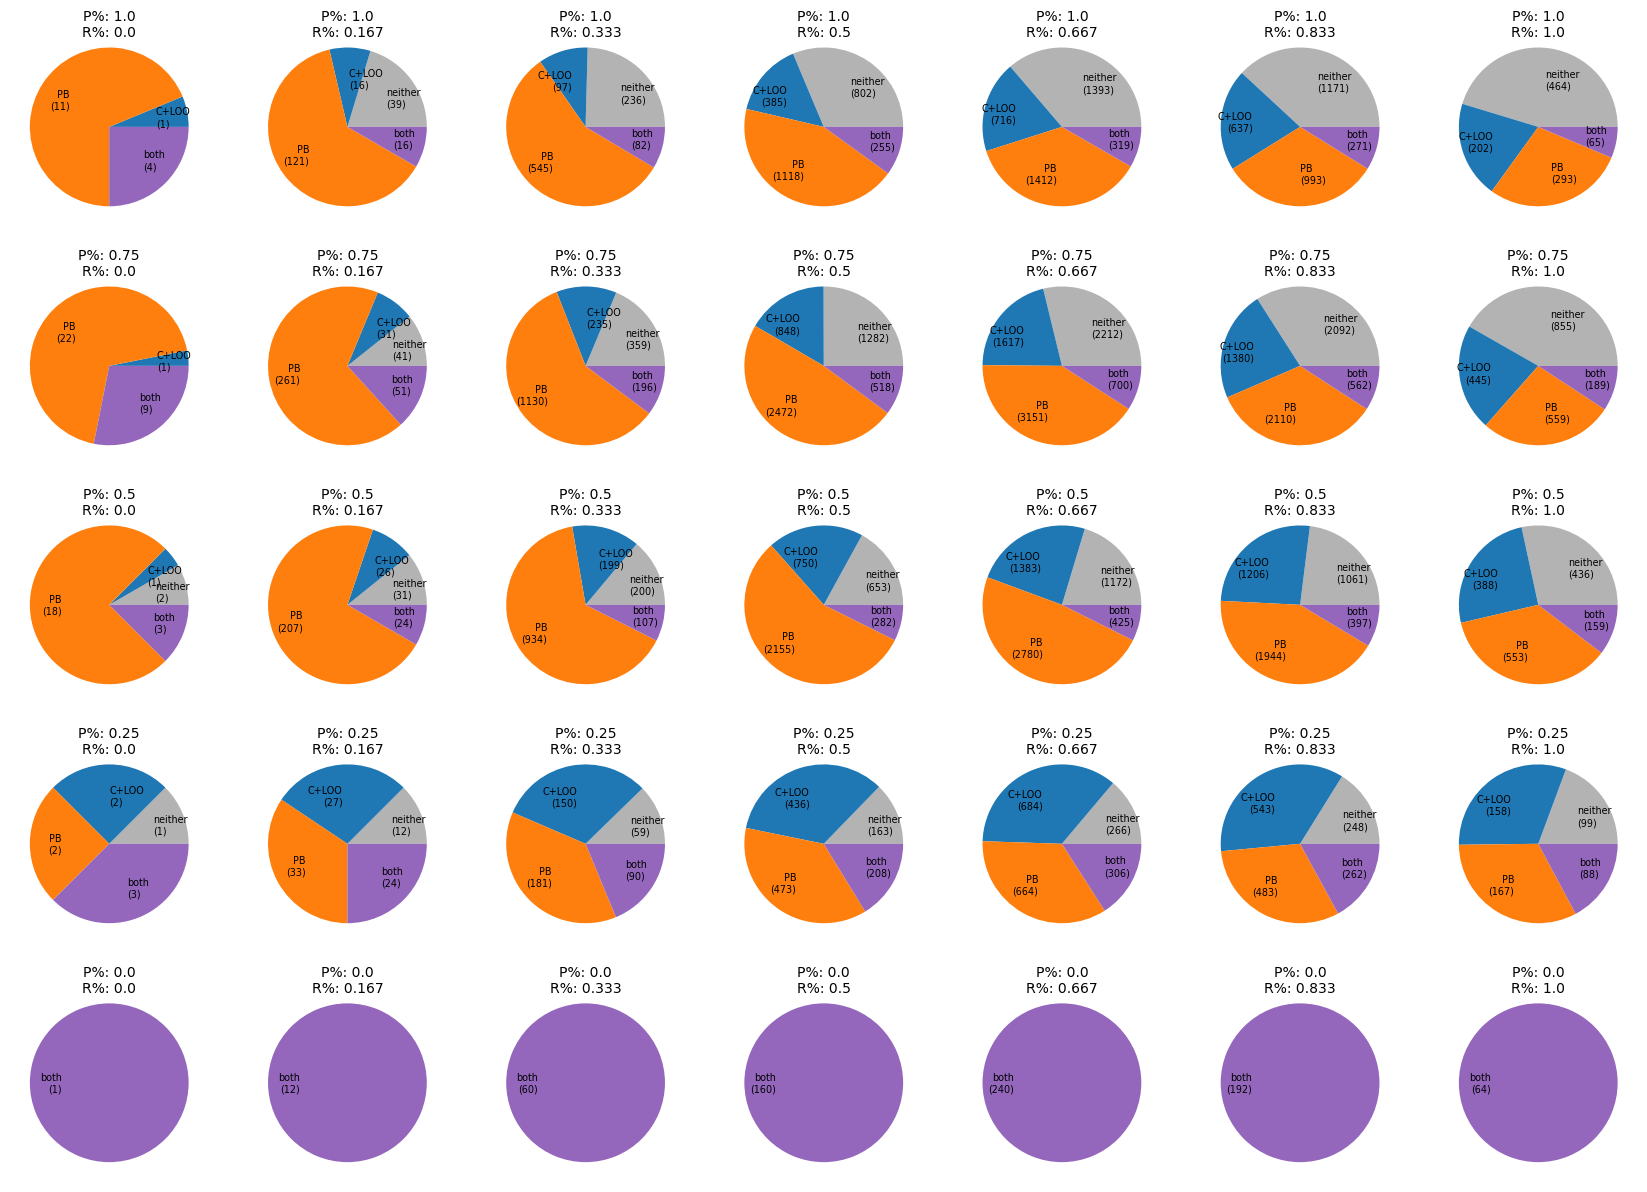

In [36]:
key_r, key_c = "pathway_coverage", "edge_coverage"
label_r, label_c = "P%", "R%"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
val_r, val_c = np.sort(row.unique())[::-1], np.sort(col.unique())
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = [
        np.where(
            (dat.loc[:, key_r] == val_r[i // ncol]) & (dat.loc[:, key_c] == val_c[i % ncol]) & (dat.loc[:, "v"] == idx)
        )[0].size for idx in range(4)
    ]
    if np.sum(_d) == 0:
        a.text(0.5, 0.5, "N/A", ha="center", va="center")
        a.text(
            0.5, .95, 
            f"{label_r}: {(val_r[i // ncol]).round(3)}\n{label_c}: {(val_c[i % ncol]).round(3)}", 
            ha="center", va="bottom"
        )
        a.axis("off")
    else:
        a.pie(
            _d, labels=[f"{k}\n({_d[idx]})" if _d[idx]!=0 else "" for idx, k in d_label.items()], 
            labeldistance=.6, textprops={'size': 'x-small'},
            colors=[d_color[k] for k in d_label]
        )
        latexify = lambda name: "_{".join(name.split("_")) + "}"
        a.text(
            0, 1.1, 
            f"{label_r}: {(val_r[i // ncol]).round(3)}\n{label_c}: {(val_c[i % ncol]).round(3)}", 
            ha="center", va="bottom"
        )
    # if np.sum(_d) == 0:
    #     a.axis("off")
        # a.text(
        #     0, 1.1, 
        #     f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )
    # if np.sum(_d) == 0:
    #     a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

/tmp/ipykernel_71057/2527072464.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(6, 3))


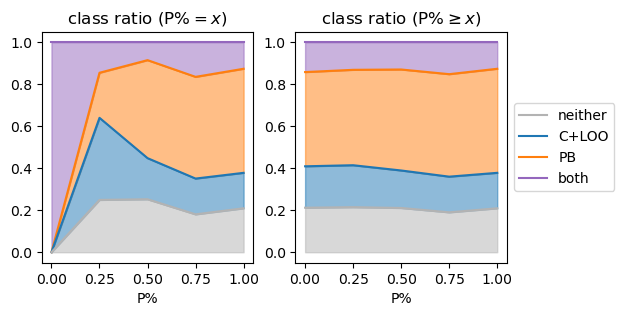

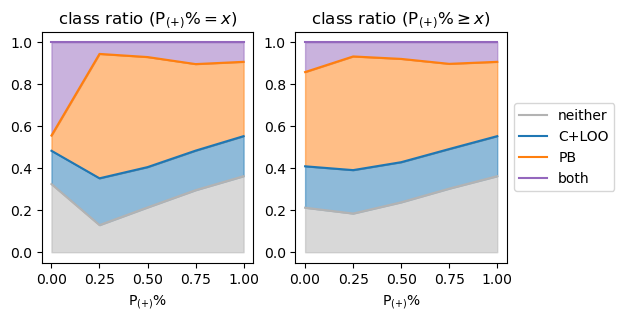

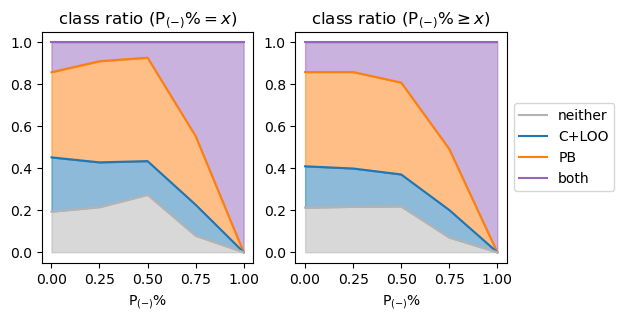

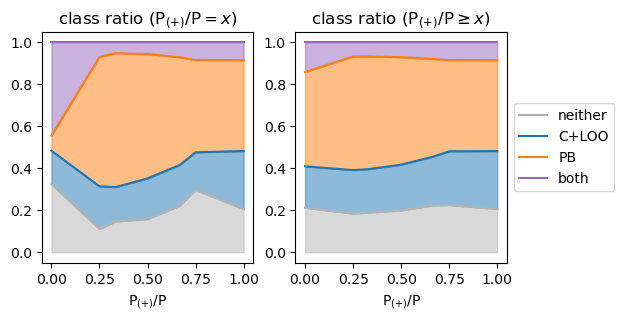

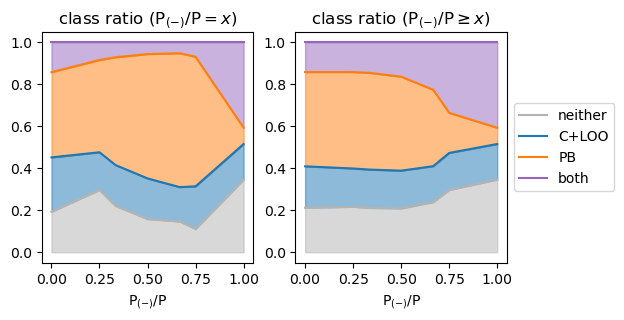

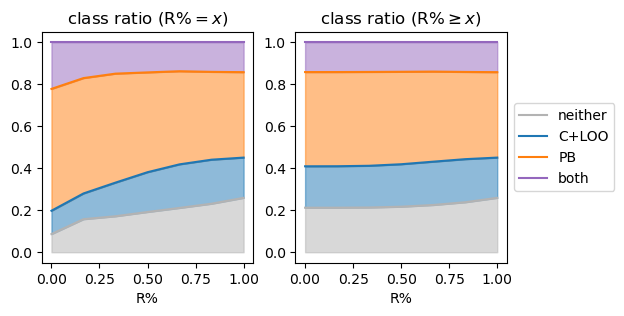

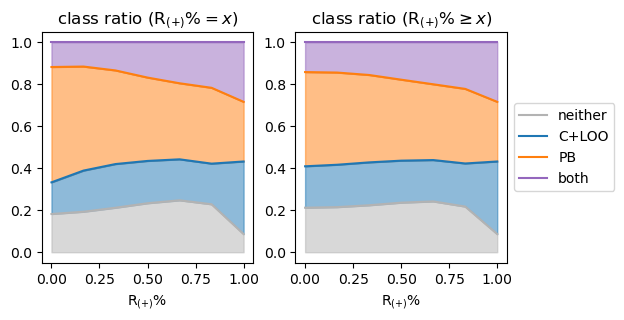

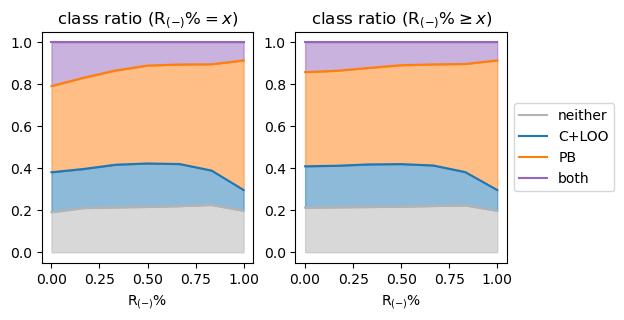

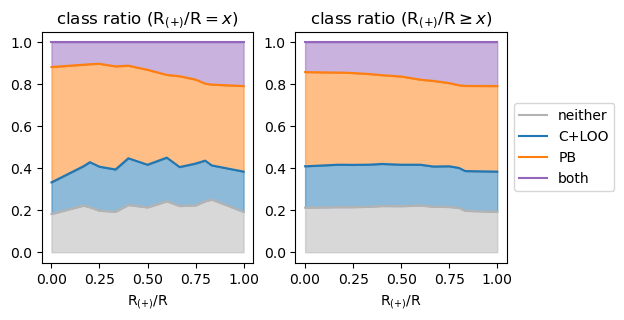

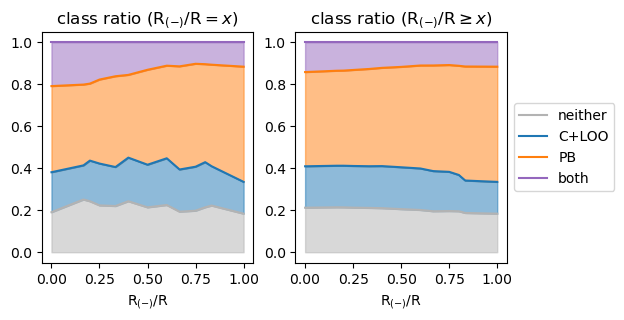

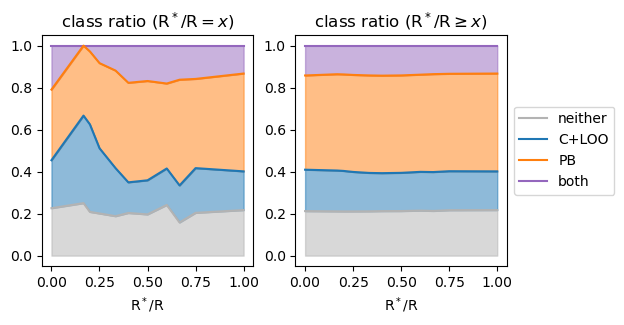

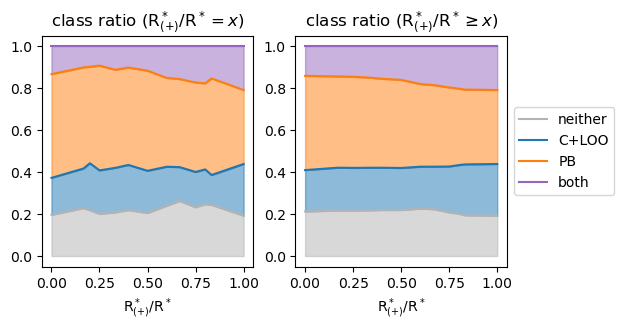

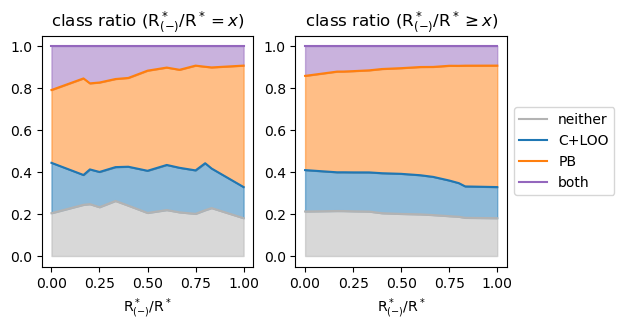

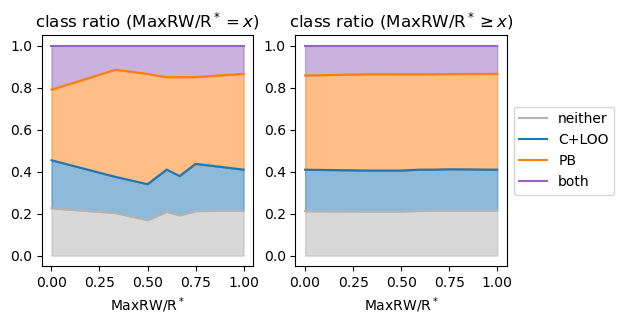

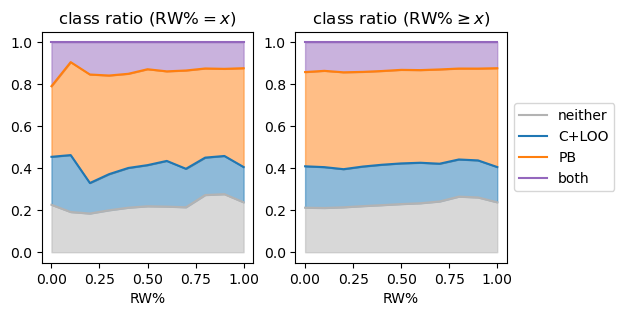

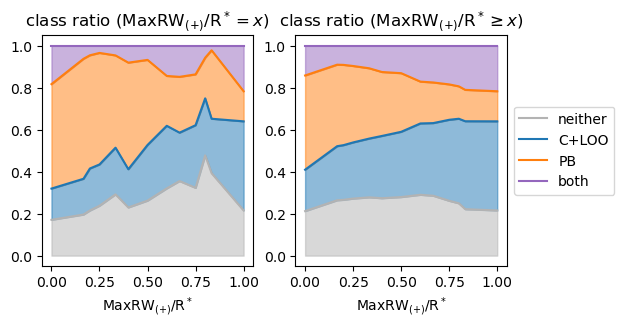

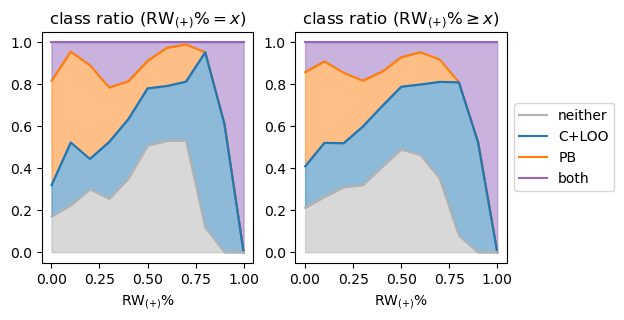

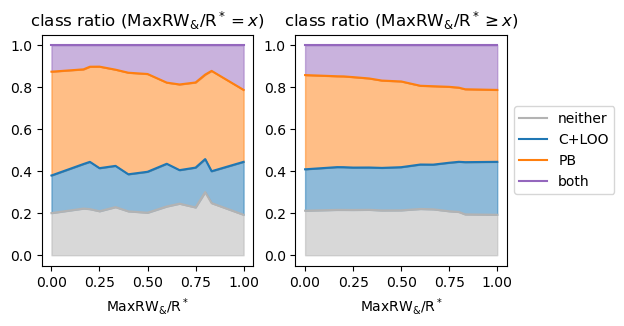

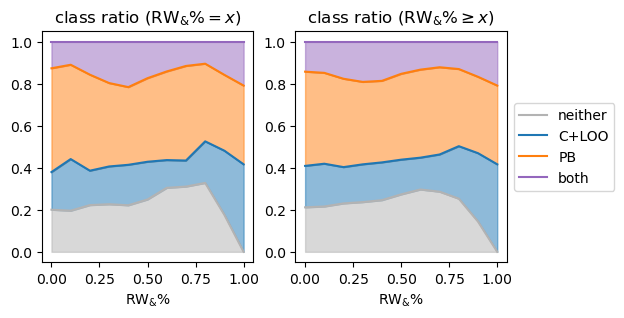

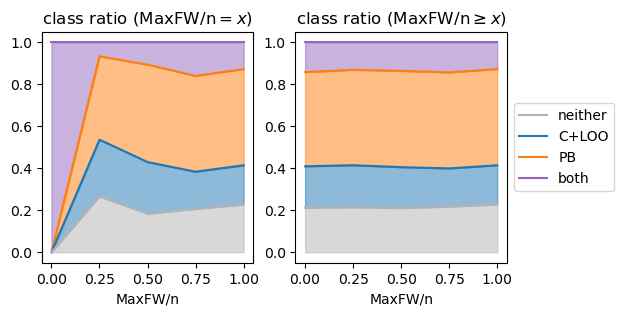

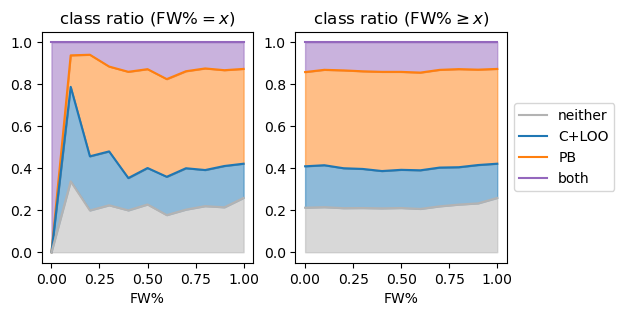

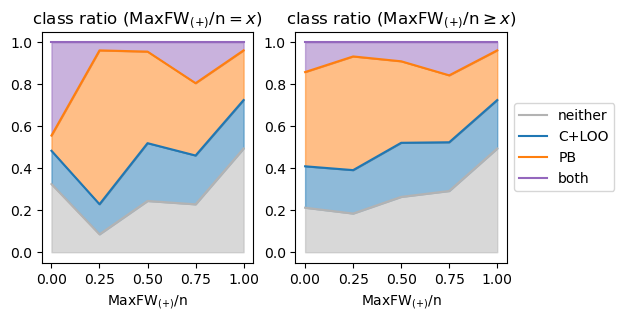

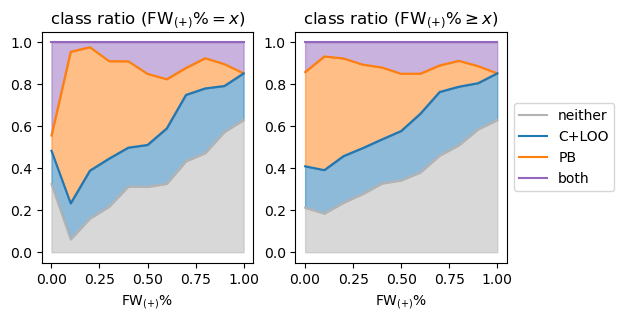

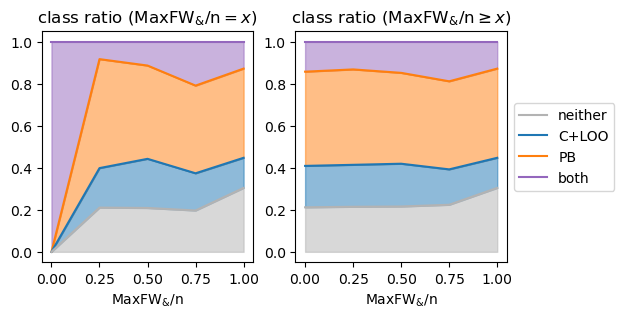

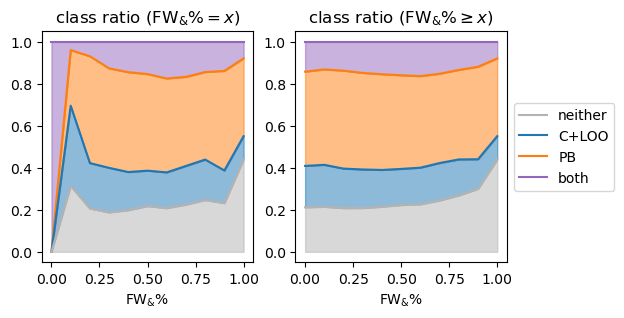

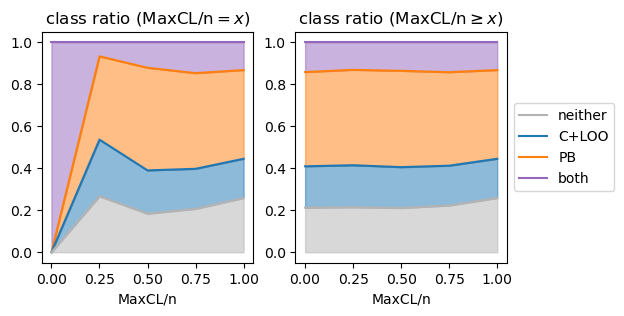

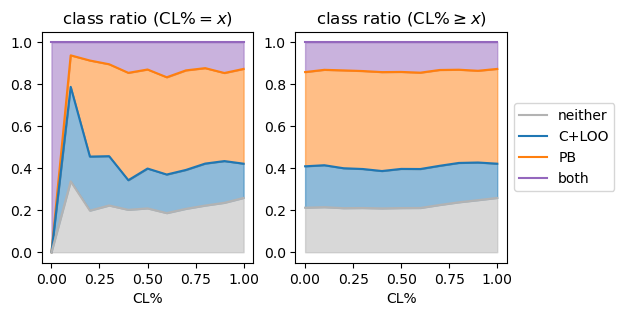

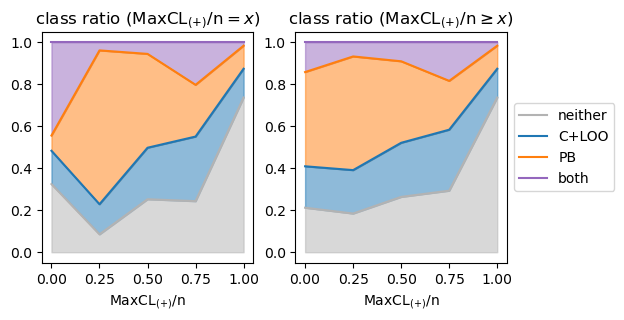

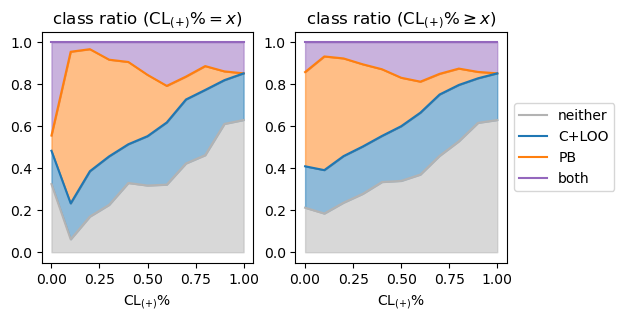

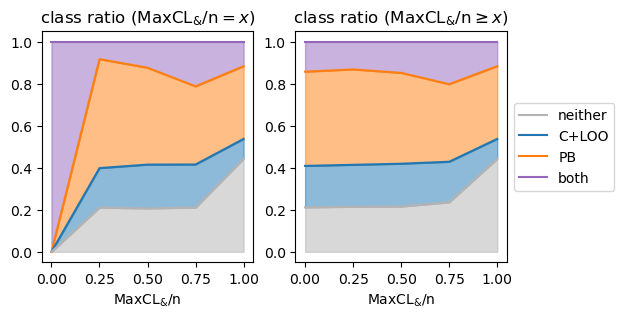

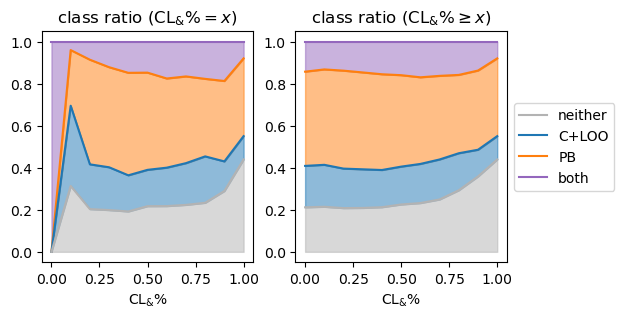

In [81]:
for key in [
    v for v in df.columns
]:
    label=feat_names_short[key] if key in feat_names_short else key.upper()
    
    stdf2 = stacked_tally(dat, key, "", stack_key="v", ratio=True)
    stdf3 = stacked_tally(dat, key, "", stack_key="v", ratio=True, geq=True)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    for i, k in enumerate(stdf2.loc[:, "index"].unique()):
        sns.lineplot(
            data=stdf2[stdf2.loc[:, "index"] == k],
            x="key", y="",
            color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
            zorder=-i, label=k
        )
        sns.lineplot(
            data=stdf3[stdf3.loc[:, "index"] == k],
            x="key", y="",
            color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
            zorder=-i, label=k
        )

    for line_idx, line in enumerate(ax[0].lines):
        x0, y0 = line.get_xydata().T
        ax[0].fill_between(x0, 0 if line_idx == 0 else bottom, y0, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
        bottom = y0

    for line_idx, line in enumerate(ax[1].lines):
        x1, y1 = line.get_xydata().T
        ax[1].fill_between(x1, 0 if line_idx == 0 else bottom, y1, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
        bottom = y1

    # ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
    # ax.xaxis.set_tick_params(rotation=90)

    ax[0].get_legend().remove()
    ax[1].legend(loc="center left", bbox_to_anchor=(1, .5))
    ax[0].set(xlabel=label, title=f"class ratio ({label}$=x$)")
    ax[1].set(xlabel=label, title=f"class ratio ({label}$\geq x$)")

    # if conf.savefig:
    #     fig.savefig(f"{conf.out}/bar_{key}{conf.suffix}", **kwarg_savefig)

In [123]:
df

,pathway_coverage,positive_pathway_coverage,negative_pathway_coverage,pathway_positivity,pathway_negativity,edge_coverage,positive_edge_coverage,negative_edge_coverage,edge_positivity,edge_negativity,...,max_positive_factor_density,mean_positive_factor_density,max_synergetic_factor_density,mean_synergetic_factor_density,max_cascade_length_ratio,mean_cascade_length_ratio,max_positive_cascade_length_ratio,mean_positive_cascade_length_ratio,max_synergetic_cascade_length_ratio,mean_synergetic_cascade_length_ratio
0,1.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.00,0.0,0.25,0.4,1.00,1.0,0.00,0.0,0.25,0.4
1,1.0,0.0,1.0,0.0,1.0,0.833333,0.000000,0.833333,0.000000,1.000000,...,0.00,0.0,0.25,0.4,0.75,0.9,0.00,0.0,0.25,0.4
2,1.0,0.0,1.0,0.0,1.0,1.000000,0.166667,0.833333,0.166667,0.833333,...,0.00,0.0,0.50,0.5,1.00,1.0,0.00,0.0,0.50,0.5
3,1.0,0.0,1.0,0.0,1.0,0.833333,0.000000,0.833333,0.000000,1.000000,...,0.00,0.0,0.25,0.4,1.00,1.0,0.00,0.0,0.25,0.4
4,1.0,0.0,1.0,0.0,1.0,0.666667,0.000000,0.666667,0.000000,1.000000,...,0.00,0.0,0.25,0.4,0.75,0.8,0.00,0.0,0.25,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59044,1.0,1.0,0.0,1.0,0.0,0.666667,0.666667,0.000000,1.000000,0.000000,...,0.75,0.8,0.75,0.8,0.75,0.8,0.75,0.8,0.75,0.8
59045,1.0,1.0,0.0,1.0,0.0,0.833333,0.833333,0.000000,1.000000,0.000000,...,1.00,1.0,1.00,1.0,1.00,1.0,1.00,1.0,1.00,1.0
59046,1.0,1.0,0.0,1.0,0.0,1.000000,0.833333,0.166667,0.833333,0.166667,...,0.75,0.9,0.75,0.9,1.00,1.0,0.75,0.9,0.75,0.9
59047,1.0,1.0,0.0,1.0,0.0,0.833333,0.833333,0.000000,1.000000,0.000000,...,0.75,0.9,0.75,0.9,0.75,0.9,0.75,0.9,0.75,0.9


In [126]:
df

,pathway_coverage,positive_pathway_coverage,negative_pathway_coverage,pathway_positivity,pathway_negativity,edge_coverage,positive_edge_coverage,negative_edge_coverage,edge_positivity,edge_negativity,...,max_positive_factor_density,mean_positive_factor_density,max_synergetic_factor_density,mean_synergetic_factor_density,max_cascade_length_ratio,mean_cascade_length_ratio,max_positive_cascade_length_ratio,mean_positive_cascade_length_ratio,max_synergetic_cascade_length_ratio,mean_synergetic_cascade_length_ratio
0,1.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.00,0.0,0.25,0.4,1.00,1.0,0.00,0.0,0.25,0.4
1,1.0,0.0,1.0,0.0,1.0,0.833333,0.000000,0.833333,0.000000,1.000000,...,0.00,0.0,0.25,0.4,0.75,0.9,0.00,0.0,0.25,0.4
2,1.0,0.0,1.0,0.0,1.0,1.000000,0.166667,0.833333,0.166667,0.833333,...,0.00,0.0,0.50,0.5,1.00,1.0,0.00,0.0,0.50,0.5
3,1.0,0.0,1.0,0.0,1.0,0.833333,0.000000,0.833333,0.000000,1.000000,...,0.00,0.0,0.25,0.4,1.00,1.0,0.00,0.0,0.25,0.4
4,1.0,0.0,1.0,0.0,1.0,0.666667,0.000000,0.666667,0.000000,1.000000,...,0.00,0.0,0.25,0.4,0.75,0.8,0.00,0.0,0.25,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59044,1.0,1.0,0.0,1.0,0.0,0.666667,0.666667,0.000000,1.000000,0.000000,...,0.75,0.8,0.75,0.8,0.75,0.8,0.75,0.8,0.75,0.8
59045,1.0,1.0,0.0,1.0,0.0,0.833333,0.833333,0.000000,1.000000,0.000000,...,1.00,1.0,1.00,1.0,1.00,1.0,1.00,1.0,1.00,1.0
59046,1.0,1.0,0.0,1.0,0.0,1.000000,0.833333,0.166667,0.833333,0.166667,...,0.75,0.9,0.75,0.9,1.00,1.0,0.75,0.9,0.75,0.9
59047,1.0,1.0,0.0,1.0,0.0,0.833333,0.833333,0.000000,1.000000,0.000000,...,0.75,0.9,0.75,0.9,0.75,0.9,0.75,0.9,0.75,0.9
